# Caltech101 分类

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import os
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
from six.moves import urllib
import matplotlib.pyplot as plt
import numpy as np
import math

/home/han/.local/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/han/.local/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


这个数据集下载连接为google drive，无法直接从torchvision.datasets下载，可手动下载解压到指定文件夹

In [2]:
#transform = transforms.Compose([
#    transforms.Lambda(lambda x: x.convert("RGB")),
#    transforms.Resize((128, 128)),
#    transforms.ToTensor(),
#])
transform = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean = [0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 下载并加载Caltech101数据集
caltech101_dataset = torchvision.datasets.Caltech101(
    root='./data',
    download=False,  # 设置为True以从互联网下载数据集
    transform=transform
)

print(f'总数据集大小：{len(caltech101_dataset)}')

# 定义训练和测试集的大小
train_size = int(0.8 * len(caltech101_dataset))  # 例如，80%为训练集
test_size = len(caltech101_dataset) - train_size  # 剩余20%为测试集
print(f"train_size: {train_size}, test_size: {test_size}");
train_data,test_data = torch.utils.data.random_split(caltech101_dataset, [train_size, test_size])

batch_size = 8

# 创建数据加载器
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)


for images, labels in train_loader:
    #print(images.size(), labels)
    break;
    

print(images[0].numpy().shape)


总数据集大小：8677
train_size: 6941, test_size: 1736
(3, 224, 224)


In [3]:
caltech101_dataset.categories

['Faces',
 'Faces_easy',
 'Leopards',
 'Motorbikes',
 'accordion',
 'airplanes',
 'anchor',
 'ant',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly',
 'camera',
 'cannon',
 'car_side',
 'ceiling_fan',
 'cellphone',
 'chair',
 'chandelier',
 'cougar_body',
 'cougar_face',
 'crab',
 'crayfish',
 'crocodile',
 'crocodile_head',
 'cup',
 'dalmatian',
 'dollar_bill',
 'dolphin',
 'dragonfly',
 'electric_guitar',
 'elephant',
 'emu',
 'euphonium',
 'ewer',
 'ferry',
 'flamingo',
 'flamingo_head',
 'garfield',
 'gerenuk',
 'gramophone',
 'grand_piano',
 'hawksbill',
 'headphone',
 'hedgehog',
 'helicopter',
 'ibis',
 'inline_skate',
 'joshua_tree',
 'kangaroo',
 'ketch',
 'lamp',
 'laptop',
 'llama',
 'lobster',
 'lotus',
 'mandolin',
 'mayfly',
 'menorah',
 'metronome',
 'minaret',
 'nautilus',
 'octopus',
 'okapi',
 'pagoda',
 'panda',
 'pigeon',
 'pizza',
 'platypus',
 'pyramid',
 'revolver',
 'rhino',
 'rooster',
 'saxophone',
 'sc

In [4]:
def images_show(imgs,labs=[]):
    i=0
    h=math.ceil(len(imgs)/2)
  
    
    for img in imgs:
        img = img / 2 + 0.5  
        npimg = img.numpy()
        plt.subplot(2,h,i+1);
        if labs != []:
            plt.title(caltech101_dataset.categories[labs[i]])
        plt.imshow((np.transpose(npimg, (1, 2, 0))))
        #print(npimg.shape)
        i+=1
        #plt.imshow(npimg)
        
plt.show()

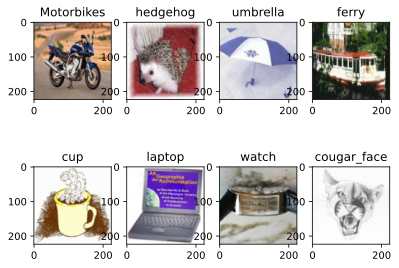

In [5]:
images_show(images,labels)

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import pretrainedmodels

# the resnet34 model
class ResNet34(nn.Module):
    def __init__(self, pretrained):
        super(ResNet34, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained = None)
        # change the classification layer
        self.l0= nn.Linear(512, len(caltech101_dataset.categories))
        self.dropout = nn.Dropout2d(0.4)
        
    def forward(self, x):
        # get the batch size only, ignore(c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        x = self.dropout(x)
        l0 = self.l0(x)
        return l0
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU
#device = "cpu"
model = ResNet34(pretrained=True).to(device)
print(model)

/home/han/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/han/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet34(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [7]:
from torchsummary import summary
print(summary(model, input_size=(3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

/usr/lib/python3.11/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [8]:
import torch.optim as optim
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-4)

In [ ]:
# training function
from tqdm import tqdm
epochs = 20 # Number of epochs


for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 2.684
[1,   200] loss: 1.962
[1,   300] loss: 1.640
[1,   400] loss: 1.215
[1,   500] loss: 1.144
[1,   600] loss: 0.875
[1,   700] loss: 0.757
[1,   800] loss: 0.695
[2,   100] loss: 0.397
[2,   200] loss: 0.389
[2,   300] loss: 0.351
[2,   400] loss: 0.342
[2,   500] loss: 0.321
[2,   600] loss: 0.303
[2,   700] loss: 0.301
[2,   800] loss: 0.268
[3,   100] loss: 0.128
[3,   200] loss: 0.160
[3,   300] loss: 0.119
[3,   400] loss: 0.129
[3,   500] loss: 0.110
[3,   600] loss: 0.158
[3,   700] loss: 0.165
[3,   800] loss: 0.187
[4,   100] loss: 0.113
[4,   200] loss: 0.123
[4,   300] loss: 0.117
[4,   400] loss: 0.150
[4,   500] loss: 0.138
[4,   600] loss: 0.147
[4,   700] loss: 0.144
[4,   800] loss: 0.130
[5,   100] loss: 0.180
[5,   200] loss: 0.093
[5,   300] loss: 0.095
[5,   400] loss: 0.137
[5,   500] loss: 0.129
[5,   600] loss: 0.096
[5,   700] loss: 0.102
[5,   800] loss: 0.115
[6,   100] loss: 0.160
[6,   200] loss: 0.086
[6,   300] loss: 0.116
[6,   400] 

In [ ]:
PATH = './caltech101_net.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
images_show(images,labels)
#print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
PATH = './caltech101_net.pth'
net = ResNet34(False)
net.load_state_dict(torch.load(PATH))

torch.Size([8, 3, 224, 224])
tensor([42, 91, 43, 43, 63, 63,  2, 63])


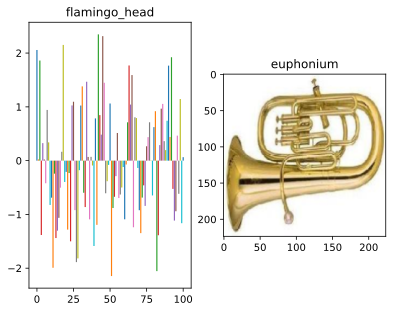

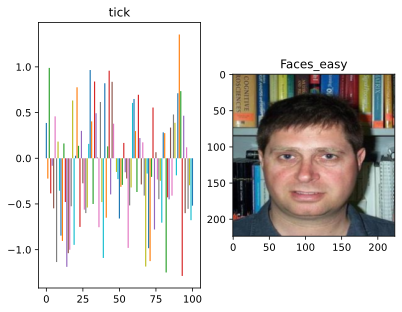

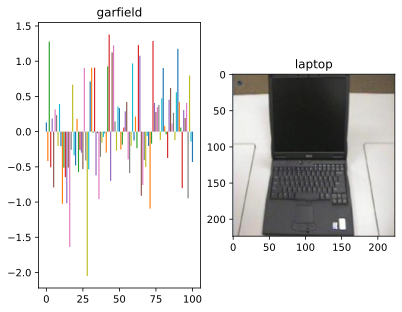

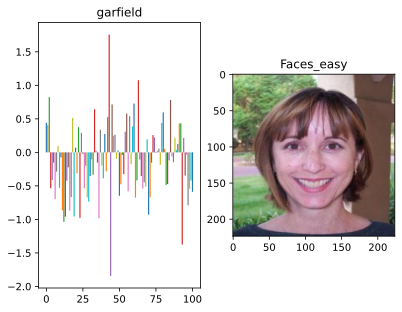

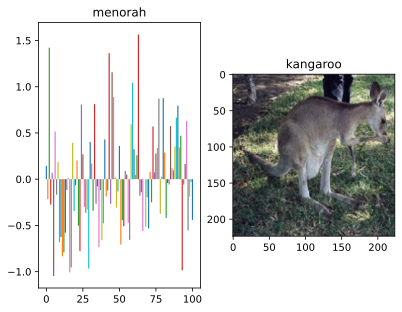

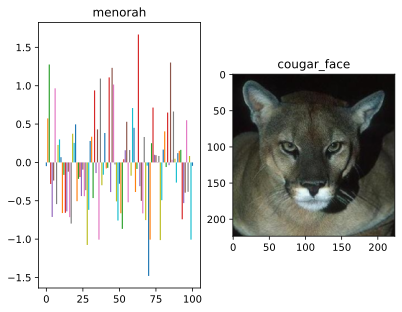

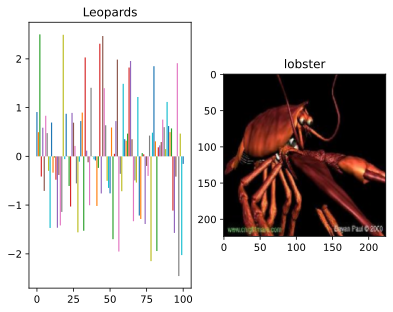

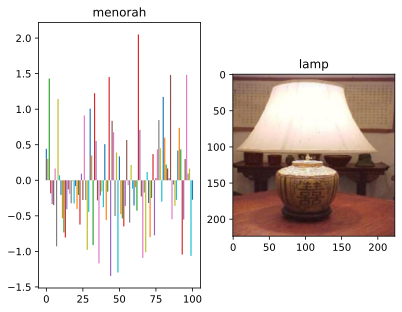

In [23]:
outputs = net(images)
print(images.shape)
#print(outputs)
#for i in range(outputs):
_, predicted = torch.max(outputs, 1)

print(predicted)
for j in range(8):
    plt.subplot(1,2,1)
    for i in range(101):
        plt.bar(i,outputs[j][i].item())
    plt.title(caltech101_dataset.categories[predicted[j]])
    plt.subplot(1,2,2)

    img = images[j] / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow((np.transpose(npimg, (1, 2, 0))))
    plt.title(caltech101_dataset.categories[labels[j]])
    plt.savefig(f'./fig/{j}.svg')
    plt.show()
    

In [42]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 91 %


In [45]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in caltech101_dataset.categories}
total_pred = {classname: 0 for classname in caltech101_dataset.categories}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[caltech101_dataset.categories[label]] += 1
            total_pred[caltech101_dataset.categories[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Faces is 97.6 %
Accuracy for class: Faces_easy is 97.7 %
Accuracy for class: Leopards is 100.0 %
Accuracy for class: Motorbikes is 100.0 %
Accuracy for class: accordion is 90.0 %
Accuracy for class: airplanes is 98.8 %
Accuracy for class: anchor is 62.5 %
Accuracy for class: ant   is 77.8 %
Accuracy for class: barrel is 100.0 %
Accuracy for class: bass  is 57.1 %
Accuracy for class: beaver is 83.3 %
Accuracy for class: binocular is 100.0 %
Accuracy for class: bonsai is 94.4 %
Accuracy for class: brain is 95.0 %
Accuracy for class: brontosaurus is 66.7 %
Accuracy for class: buddha is 100.0 %
Accuracy for class: butterfly is 88.9 %
Accuracy for class: camera is 100.0 %
Accuracy for class: cannon is 54.5 %
Accuracy for class: car_side is 100.0 %
Accuracy for class: ceiling_fan is 90.0 %
Accuracy for class: cellphone is 88.9 %
Accuracy for class: chair is 76.9 %
Accuracy for class: chandelier is 95.0 %
Accuracy for class: cougar_body is 44.4 %
Accuracy for class: cougar

参考：

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

https://colab.research.google.com/github/ashishpatel26/Awesome-Pytorch-Tutorials/blob/main/17.Pytorch%20Transfer%20learning%20with%20Caltech101.ipynb
